In [1]:
import sys
import os
import torch
import torch.distributed as dist
import torchsummary
import torch.optim as optim
import numpy as np
import torchvision.utils
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from torch import nn, Tensor
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import v2
from PIL import Image
from CustomDataset import CustomDataset
from metrics import evaluate

transform = v2.Compose([
    # v2.Resize((224,224)),
    # v2.RandomRotation(degrees=(0,180)),
    v2.Compose([v2.ToImage(),v2.ToDtype(torch.float32,scale=True)]),
    # v2.Normalize([0.485], [0.229]),
])
train_dataset = CustomDataset(root_dir="../training",transform=transform)
val_dataset = CustomDataset(root_dir="../validation",transform=transform)

train_loader = DataLoader(train_dataset,batch_size=32,shuffle=False)
val_loader = DataLoader(val_dataset,batch_size=32,shuffle=False)

Mahdinejad, Mahsa & Murphy, Aidan & Tetteh, Michael & de Lima, Allan & Healy, Patrick & Ryan, Conor. (2023). Grammar-Guided Evolution of the U-Net. 10.1007/978-3-031-30229-9_43. 
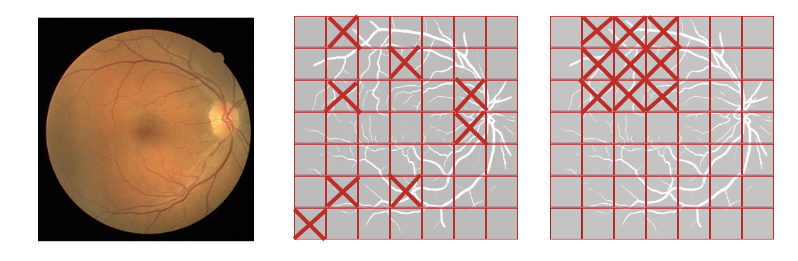

In [2]:
# Construction of DropBlock
"""
Instead of dropping random neurons from the neural network, DropBlock instead drops the entire block with specified size.
"""
class DropBlock(nn.Module):
    def __init__(self, block_size: int = 5, p: float = 0.1):
        super().__init__()
        self.block_size = block_size
        self.p = p

    def calculate_gamma(self, x: Tensor) -> float:
        invalid = (1 - self.p) / (self.block_size ** 2)
        valid = (x.shape[-1] ** 2) / ((x.shape[-1] - self.block_size + 1) ** 2)
        return invalid * valid
    
    def forward(self, x: Tensor) -> Tensor:
        N, C, H, W = x.size()
        if self.training:
            gamma = self.calculate_gamma(x)
            mask_shape = (N, C, H - self.block_size + 1, W - self.block_size + 1)
            mask = torch.bernoulli(torch.full(mask_shape, gamma, device=x.device))
            mask = F.pad(mask, [self.block_size // 2] * 4, value=0)
            mask_block = 1 - F.max_pool2d(
                mask,
                kernel_size=(self.block_size, self.block_size),
                stride=(1, 1),
                padding=(self.block_size // 2, self.block_size // 2),
            )
            x = mask_block * x * (mask_block.numel() / mask_block.sum())
        return x

# Double Conv layer with DropBlock instead of Dropout layer
class DoubleConv(nn.Sequential):
    def __init__(self, input_channel, output_channel, middle=None):
        if middle is None:
            middle = output_channel
        super(DoubleConv, self).__init__(
            nn.Conv2d(input_channel, middle, kernel_size=3, padding=1, bias=False),
            DropBlock(7, 0.9),
            nn.BatchNorm2d(middle),
            nn.ReLU(inplace=True),
            nn.Conv2d(middle, output_channel, kernel_size=3, padding=1, bias=False),
            DropBlock(7, 0.9),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(inplace=True)
        )

# Downsampling helper function
class Down(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__(
            nn.MaxPool2d(2, stride=2),
            DoubleConv(in_channels, out_channels)
        )

# The Downsampling layer before the attention mechanism
class LastDown(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super(LastDown, self).__init__(
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            DropBlock(7, 0.18),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

# Up Sampling Block helper
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diff_y = x2.size()[2] - x1.size()[2]
        diff_x = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diff_x // 2, diff_x - diff_x // 2,
                        diff_y // 2, diff_y - diff_y // 2])

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class Out_Conv(nn.Sequential):
    def __init__(self, in_channels, num_classes):
        super(Out_Conv, self).__init__(
            nn.Conv2d(in_channels, num_classes, kernel_size=1),
        )

# Attention Block 
class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=7, stride=1, padding=3)

    def forward(self, x):
        x1 = torch.mean(x, dim=1, keepdim=True)
        x2, _ = torch.max(x, 1, keepdim=True)
        x3 = torch.cat((x1, x2), dim=1)
        x4 = torch.sigmoid(self.conv(x3))
        x = x4 * x
        assert len(x.shape) == 4, f"Attention"
        return x

# Spatial Attention Main Class
class SA_UNet(nn.Module):
    def __init__(self,
                 in_channels: int = 1,
                 num_classes: int = 1,
                 bilinear: bool = False,
                 base_c: int = 16):
        super(SA_UNet, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.bilinear = bilinear
        # Downsampling
        self.conv1 = DoubleConv(in_channels, base_c)
        self.down1 = Down(base_c, base_c * 2)
        self.down2 = Down(base_c * 2, base_c * 4)
        self.down3 = LastDown(base_c * 4, base_c * 8)
        # Attention Block
        self.attn = Attention()
        self.conv2 = nn.Sequential(nn.Conv2d(base_c * 8, base_c * 8, kernel_size=3, padding=1, bias=False),
                                   DropBlock(7, 0.9),
                                   nn.BatchNorm2d(base_c * 8),
                                   nn.ReLU(inplace=True))
        # UpSampling
        self.up1 = Up(base_c * 8, base_c * 4, bilinear)
        self.up2 = Up(base_c * 4, base_c * 2, bilinear)
        self.up3 = Up(base_c * 2, base_c, bilinear)
        self.out_conv = Out_Conv(base_c, num_classes)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.attn(x4)
        x6 = self.conv2(x5)
        x = self.up1(x6, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        logits = self.out_conv(x)

        return logits

## Self Attention UNet Architecture

<p>Guo, Changlu, Márton Szemenyei, Yugen Yi, Wenle Wang, Buer Chen, and Changqi Fan. "Sa-unet: Spatial attention u-net for retinal vessel segmentation." In 2020 25th international conference on pattern recognition (ICPR), pp. 1236-1242. IEEE, 2021.</p>

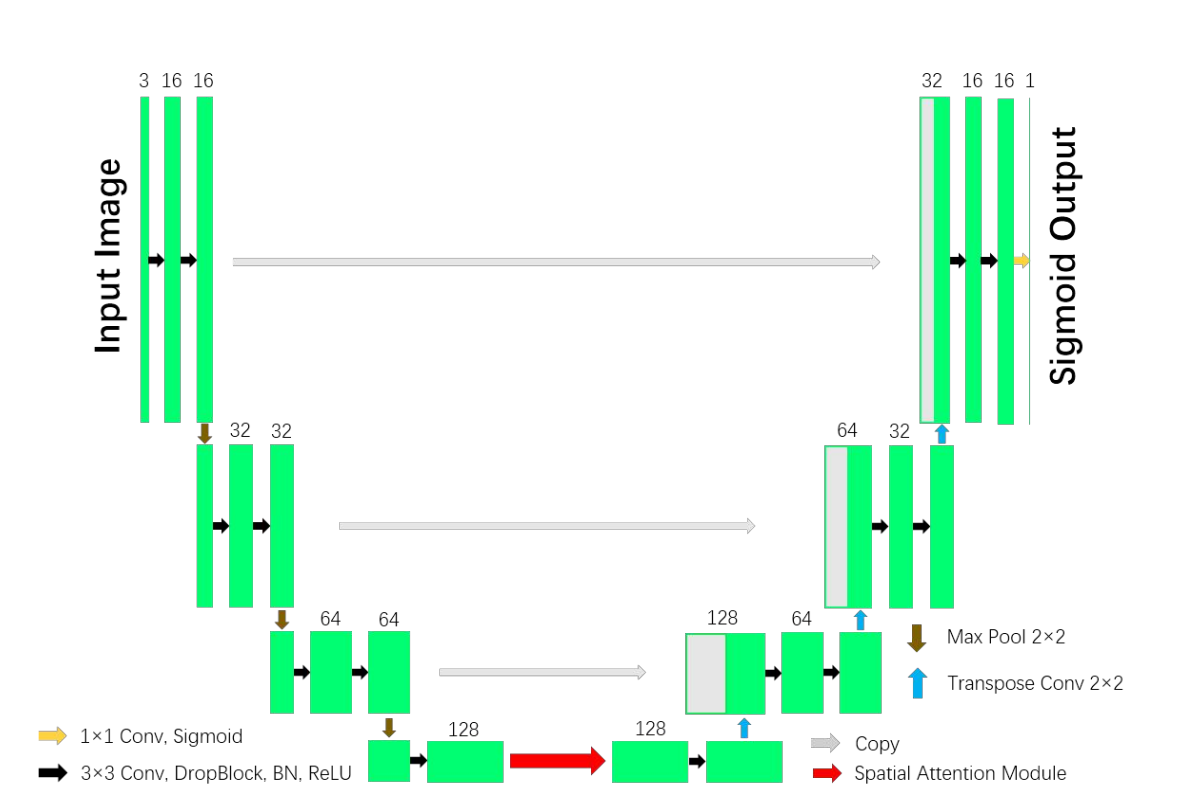

In [3]:
model = SA_UNet(in_channels=1, num_classes=1).to('cuda')
torchsummary.summary(model, input_size=(1,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             144
         DropBlock-2         [-1, 16, 128, 128]               0
       BatchNorm2d-3         [-1, 16, 128, 128]              32
              ReLU-4         [-1, 16, 128, 128]               0
            Conv2d-5         [-1, 16, 128, 128]           2,304
         DropBlock-6         [-1, 16, 128, 128]               0
       BatchNorm2d-7         [-1, 16, 128, 128]              32
              ReLU-8         [-1, 16, 128, 128]               0
         MaxPool2d-9           [-1, 16, 64, 64]               0
           Conv2d-10           [-1, 32, 64, 64]           4,608
        DropBlock-11           [-1, 32, 64, 64]               0
      BatchNorm2d-12           [-1, 32, 64, 64]              64
             ReLU-13           [-1, 32, 64, 64]               0
           Conv2d-14           [-1, 32,

In [5]:
import torch.optim as optim
import matplotlib.pyplot as plt
import wandb

train_iou_history = []
val_iou_history = []

device = torch.device('cuda')


criterion = nn.BCELoss()
# Using the Adam Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
logs = wandb.init(project="SA_Unet model")

best_acc = 0

num_epochs = 100 
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    # Going though all the training data
    for data in train_loader:
        # extracting the images, masks, eye_masks from the dataloader
        for images, masks, eye_masks in data:
            images = images.cuda()
            masks = masks.cuda()
            # Pushing the images, masks to the GPU
            optimizer.zero_grad()
            
            outputs = model(images)
            outputs = torch.sigmoid(outputs)
            # Calculating the loss
            loss = criterion(outputs, masks)

            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    # Getting all the performance metrics
    acc, se, sp, F1, pr, AUC_ROC, dice, iou = evaluate(model, val_loader, num_classes=2)
    logs.log({
        "acc": acc,
        "sensitivity": se,
        "specificity": sp,
        "F1-score": F1,
        "AUC_ROC": AUC_ROC,
        "Dice": dice,
        "epoch": epoch,
        "IOU": iou
    })
    # Selecting best accuracy
    if best_acc < acc:
        best_acc = acc
        print(f"Best accuracy attained: {best_acc*100:.4f}%")
        torch.save(model.state_dict(),"SA_UNet_model.pth")
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {acc*100:.4f}%, IOU: {iou}')

wandb: Currently logged in as: battulasaikiran2002. Use `wandb login --relogin` to force relogin


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]


Best accuracy attained: 92.1956%
Epoch [1/100], Loss: 69.9169, Accuracy: 92.1956%, IOU: 0.4687973595091275


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


Best accuracy attained: 93.3878%
Epoch [2/100], Loss: 39.7752, Accuracy: 93.3878%, IOU: 0.5103874361231213


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.10s/it]


Best accuracy attained: 94.2008%
Epoch [3/100], Loss: 32.9905, Accuracy: 94.2008%, IOU: 0.563092671689533


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]


Epoch [4/100], Loss: 30.1450, Accuracy: 94.1772%, IOU: 0.593338770596754


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]


Best accuracy attained: 94.5534%
Epoch [5/100], Loss: 28.5024, Accuracy: 94.5534%, IOU: 0.6039434002978461


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]


Best accuracy attained: 94.9570%
Epoch [6/100], Loss: 27.0997, Accuracy: 94.9570%, IOU: 0.6146219048471678


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


Epoch [7/100], Loss: 26.0627, Accuracy: 94.3523%, IOU: 0.6206160894462041


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


Epoch [8/100], Loss: 25.4966, Accuracy: 94.8863%, IOU: 0.6323516946463358


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


Best accuracy attained: 95.0190%
Epoch [9/100], Loss: 24.7521, Accuracy: 95.0190%, IOU: 0.5985808699968316


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


Best accuracy attained: 95.1663%
Epoch [10/100], Loss: 24.4646, Accuracy: 95.1663%, IOU: 0.6496783480757758


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.21s/it]


Best accuracy attained: 95.2428%
Epoch [11/100], Loss: 24.1565, Accuracy: 95.2428%, IOU: 0.6355544777143569


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


Epoch [12/100], Loss: 23.4782, Accuracy: 95.1043%, IOU: 0.6216917385302839


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]


Best accuracy attained: 95.4403%
Epoch [13/100], Loss: 23.3221, Accuracy: 95.4403%, IOU: 0.6264680775858107


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


Epoch [14/100], Loss: 22.8991, Accuracy: 95.0730%, IOU: 0.5756930013497671


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


Epoch [15/100], Loss: 22.6128, Accuracy: 95.2812%, IOU: 0.6183139209591207


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


Epoch [16/100], Loss: 22.1483, Accuracy: 95.3061%, IOU: 0.6239827284500712


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


Epoch [17/100], Loss: 22.1414, Accuracy: 94.9060%, IOU: 0.5721731330312434


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]


Best accuracy attained: 95.4579%
Epoch [18/100], Loss: 22.0727, Accuracy: 95.4579%, IOU: 0.6310586898809387


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


Best accuracy attained: 95.4813%
Epoch [19/100], Loss: 22.0253, Accuracy: 95.4813%, IOU: 0.6381999323410648


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


Epoch [20/100], Loss: 21.3016, Accuracy: 95.4745%, IOU: 0.6043217340040774


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


Best accuracy attained: 95.5646%
Epoch [21/100], Loss: 21.0974, Accuracy: 95.5646%, IOU: 0.6188445744060335


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


Epoch [22/100], Loss: 21.1571, Accuracy: 94.9070%, IOU: 0.5690757068494956


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


Epoch [23/100], Loss: 21.1010, Accuracy: 93.8415%, IOU: 0.5499393472359294


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


Best accuracy attained: 95.6245%
Epoch [24/100], Loss: 20.8284, Accuracy: 95.6245%, IOU: 0.6388651913475423


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]


Epoch [25/100], Loss: 20.5723, Accuracy: 95.3752%, IOU: 0.6311073859532674


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]


Epoch [26/100], Loss: 20.4899, Accuracy: 95.3047%, IOU: 0.6030097654532819


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


Best accuracy attained: 95.6533%
Epoch [27/100], Loss: 20.1079, Accuracy: 95.6533%, IOU: 0.6435377478599549


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


Epoch [28/100], Loss: 20.0924, Accuracy: 95.5081%, IOU: 0.6277924164420082


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


Best accuracy attained: 95.7447%
Epoch [29/100], Loss: 19.8772, Accuracy: 95.7447%, IOU: 0.6578764397473562


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]


Epoch [30/100], Loss: 19.6002, Accuracy: 95.4092%, IOU: 0.6517284946782248


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]


Best accuracy attained: 95.7637%
Epoch [31/100], Loss: 19.3284, Accuracy: 95.7637%, IOU: 0.6435259051266171


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.23s/it]


Epoch [32/100], Loss: 19.3800, Accuracy: 95.3569%, IOU: 0.6048872707855134


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


Epoch [33/100], Loss: 19.5043, Accuracy: 95.4700%, IOU: 0.6493246900183814


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]


Epoch [34/100], Loss: 19.4657, Accuracy: 95.2643%, IOU: 0.6280989800180707


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]


Epoch [35/100], Loss: 18.9452, Accuracy: 95.6548%, IOU: 0.6519677399169831


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]


Epoch [36/100], Loss: 19.1861, Accuracy: 95.3085%, IOU: 0.6382612356117794


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]


Best accuracy attained: 95.9330%
Epoch [37/100], Loss: 18.7864, Accuracy: 95.9330%, IOU: 0.6958488724061421


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


Epoch [38/100], Loss: 18.5589, Accuracy: 95.7617%, IOU: 0.6541658014059066


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


Epoch [39/100], Loss: 18.6393, Accuracy: 95.8658%, IOU: 0.6648089755149115


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]


Epoch [40/100], Loss: 18.6395, Accuracy: 95.2208%, IOU: 0.6642015204543159


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]


Best accuracy attained: 96.0496%
Epoch [41/100], Loss: 18.2568, Accuracy: 96.0496%, IOU: 0.692012586622011


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]


Best accuracy attained: 96.1777%
Epoch [42/100], Loss: 18.2732, Accuracy: 96.1777%, IOU: 0.7061367877892085


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]


Epoch [43/100], Loss: 18.0496, Accuracy: 95.9726%, IOU: 0.6821693034399123


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


Epoch [44/100], Loss: 17.9391, Accuracy: 95.9264%, IOU: 0.6666608615290551


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]


Epoch [45/100], Loss: 17.9414, Accuracy: 95.8596%, IOU: 0.6649593787533896


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.10s/it]


Epoch [46/100], Loss: 17.7715, Accuracy: 95.5055%, IOU: 0.6338684016040393


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]


Epoch [47/100], Loss: 17.7504, Accuracy: 95.6246%, IOU: 0.6421661487647465


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


Epoch [48/100], Loss: 17.5927, Accuracy: 95.9838%, IOU: 0.6842105713628587


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]


Best accuracy attained: 96.1932%
Epoch [49/100], Loss: 17.5690, Accuracy: 96.1932%, IOU: 0.7013161142667135


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]


Epoch [50/100], Loss: 17.2877, Accuracy: 96.1032%, IOU: 0.702991576847576


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.10s/it]


Epoch [51/100], Loss: 17.1465, Accuracy: 95.9116%, IOU: 0.6763861981176195


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


Best accuracy attained: 96.3595%
Epoch [52/100], Loss: 17.1971, Accuracy: 96.3595%, IOU: 0.707056417635509


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]


Epoch [53/100], Loss: 17.3199, Accuracy: 95.8346%, IOU: 0.653332983879816


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


Best accuracy attained: 96.3710%
Epoch [54/100], Loss: 17.1070, Accuracy: 96.3710%, IOU: 0.7261370471545628


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


Best accuracy attained: 96.5289%
Epoch [55/100], Loss: 16.7555, Accuracy: 96.5289%, IOU: 0.7363935016450428


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]


Epoch [56/100], Loss: 16.7464, Accuracy: 96.3901%, IOU: 0.7006847736381349


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]


Epoch [57/100], Loss: 16.6042, Accuracy: 96.3788%, IOU: 0.7087666670481364


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]


Epoch [58/100], Loss: 16.5627, Accuracy: 96.4444%, IOU: 0.7060046144894191


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


Epoch [59/100], Loss: 16.8483, Accuracy: 96.2752%, IOU: 0.695590130346162


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


Best accuracy attained: 96.6004%
Epoch [60/100], Loss: 16.4441, Accuracy: 96.6004%, IOU: 0.7297872512823059


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


Epoch [61/100], Loss: 16.4803, Accuracy: 96.4900%, IOU: 0.7002077098403658


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]


Epoch [62/100], Loss: 16.2677, Accuracy: 96.4979%, IOU: 0.705992581872713


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]


Best accuracy attained: 96.6693%
Epoch [63/100], Loss: 16.3333, Accuracy: 96.6693%, IOU: 0.7169085515396936


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]


Epoch [64/100], Loss: 16.2622, Accuracy: 96.1437%, IOU: 0.6723876960220792


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]


Epoch [65/100], Loss: 16.2202, Accuracy: 96.5626%, IOU: 0.7297854832240513


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]


Epoch [66/100], Loss: 16.2743, Accuracy: 96.3831%, IOU: 0.7037145664294561


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]


Epoch [67/100], Loss: 15.9666, Accuracy: 96.6503%, IOU: 0.7011527829226993


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]


Best accuracy attained: 96.7614%
Epoch [68/100], Loss: 15.9449, Accuracy: 96.7614%, IOU: 0.7235208641915094


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


Epoch [69/100], Loss: 16.0474, Accuracy: 96.1791%, IOU: 0.6804630258253642


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


Epoch [70/100], Loss: 15.8195, Accuracy: 96.5022%, IOU: 0.6780076686825071


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


Epoch [71/100], Loss: 15.7952, Accuracy: 96.2636%, IOU: 0.7071645345006671


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


Epoch [72/100], Loss: 15.7711, Accuracy: 96.4154%, IOU: 0.6865333049070268


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]


Epoch [73/100], Loss: 15.7499, Accuracy: 96.7396%, IOU: 0.7409649668704896


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]


Best accuracy attained: 96.8236%
Epoch [74/100], Loss: 15.9108, Accuracy: 96.8236%, IOU: 0.7317949141774859


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]


Best accuracy attained: 96.9038%
Epoch [75/100], Loss: 15.5859, Accuracy: 96.9038%, IOU: 0.7265354403427668


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]


Epoch [76/100], Loss: 15.6369, Accuracy: 96.8125%, IOU: 0.7481335742133004


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]


Epoch [77/100], Loss: 15.6716, Accuracy: 95.8704%, IOU: 0.6559357492696671


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]


Epoch [78/100], Loss: 15.5678, Accuracy: 96.4809%, IOU: 0.7166592421985808


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]


Epoch [79/100], Loss: 15.5624, Accuracy: 96.6436%, IOU: 0.7380225283758981


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]


Best accuracy attained: 97.1564%
Epoch [80/100], Loss: 15.3520, Accuracy: 97.1564%, IOU: 0.7661165067127773


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]


Epoch [81/100], Loss: 15.3827, Accuracy: 96.7728%, IOU: 0.7329793152355012


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]


Epoch [82/100], Loss: 15.3346, Accuracy: 96.3301%, IOU: 0.7132235453242347


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]


Epoch [83/100], Loss: 15.3408, Accuracy: 96.7887%, IOU: 0.7264652238005683


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]


Epoch [84/100], Loss: 15.3627, Accuracy: 96.9117%, IOU: 0.7425940178689503


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]


Epoch [85/100], Loss: 15.1280, Accuracy: 96.9151%, IOU: 0.7618537562234061


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]


Epoch [86/100], Loss: 15.2797, Accuracy: 97.0987%, IOU: 0.7650284097308204


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]


Epoch [87/100], Loss: 15.2531, Accuracy: 96.6483%, IOU: 0.7525396183842704


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]


Epoch [88/100], Loss: 15.2088, Accuracy: 97.1534%, IOU: 0.74933376681237


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]


Epoch [89/100], Loss: 15.1453, Accuracy: 96.9527%, IOU: 0.7506194889545441


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]


Epoch [90/100], Loss: 14.9529, Accuracy: 97.0432%, IOU: 0.7401089111963908


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]


Epoch [91/100], Loss: 14.9508, Accuracy: 96.8543%, IOU: 0.7388759947958446


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]


Epoch [92/100], Loss: 15.0896, Accuracy: 97.0995%, IOU: 0.7594844134080978


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.21s/it]


Epoch [93/100], Loss: 14.7632, Accuracy: 97.0139%, IOU: 0.7628612983794439


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]


Epoch [94/100], Loss: 14.8864, Accuracy: 96.7371%, IOU: 0.7102978246552604


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]


Epoch [95/100], Loss: 14.7821, Accuracy: 96.9999%, IOU: 0.7462226206348056


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


Epoch [96/100], Loss: 14.8035, Accuracy: 96.8557%, IOU: 0.7439885279961995


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]


Epoch [97/100], Loss: 14.9666, Accuracy: 96.9030%, IOU: 0.7383566345487322


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]


Epoch [98/100], Loss: 14.8072, Accuracy: 97.0815%, IOU: 0.7620465985366276


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.19s/it]


Epoch [99/100], Loss: 14.8052, Accuracy: 96.9872%, IOU: 0.7675843272890364


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]


Epoch [100/100], Loss: 14.8158, Accuracy: 97.1479%, IOU: 0.7624588341940017


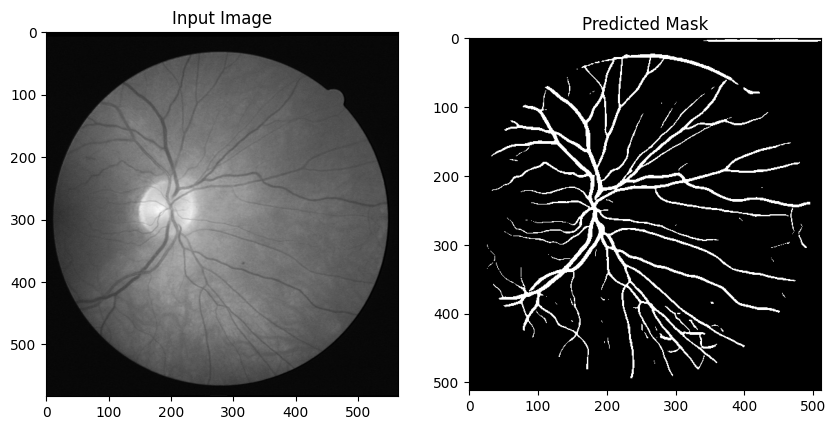

In [6]:
import torch
from torchvision import transforms
from PIL import Image

# Loading the saved model
model = SA_UNet(in_channels=1, num_classes=1).to('cuda')
model.load_state_dict(torch.load("SA_UNet_model.pth"))
model.eval()

# Transforming the image
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])


input_image = Image.open('15_test.tif').convert('L')  
input_tensor = transform(input_image).unsqueeze(0) 

# Predicting
with torch.no_grad():
    output = model(input_tensor.cuda())


predicted_mask = (output > 0.5).float()

# Plotting the input and prediction mask
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_image,cmap='gray')
plt.title('Input Image')

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask.squeeze().cpu().numpy(), cmap='gray')
plt.title('Predicted Mask')

plt.show()